In [1]:
import os
import h5py
import numpy as np
import torch
from tensorflow.keras import models, layers, preprocessing, datasets
from torch.utils.data import Dataset, DataLoader
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ScaleIntensity, ToTensor, EnsureChannelFirst
from sklearn.model_selection import train_test_split
import cv2
from torch.optim import Adam
import torch

In [2]:
def imageGenerator():
    input_folder = r'C:\Users\marto\Desktop\Szakdolgozat\pogram\brainTumor\data'
    output_folder = r'C:\Users\marto\Desktop\Szakdolgozat\pogram\brainTumor\converted_data'
    datas = []
    img_size = (256,256)
    for file_name in sorted(os.listdir(input_folder)):
        if file_name.endswith('.mat'):
            file_path = os.path.join(input_folder,file_name)
            
            with h5py.File(file_path, 'r') as f:
                image = np.array(f['cjdata/image']).T
                label = int(np.array(f['cjdata/label'])[0,0])
    
            image = image.astype(np.float64)
            im_norm = 255*(image-image.min())/(image.max()-image.min())
            im_uint8 = im_norm.astype(np.uint8)

            file_name_base = os.path.splitext(file_name)[0]
            output_file_path = os.path.join(output_folder,file_name_base + '.jpg')
    
            im_pil = Image.fromarray(im_uint8)
            im_pil = im_pil.resize(img_size)
            datas.append((np.array(im_pil,dtype=np.float32),label))
            
            im_pil.save(output_file_path)
    #return datas

In [3]:
#imageGeneratior()

In [4]:
def imageProcesser():
    input_folder = r'C:\Users\marto\Desktop\Szakdolgozat\pogram\brainTumor\data'
    datas = []
    img_size = (256,256)
    for file_name in sorted(os.listdir(input_folder)):
        if file_name.endswith('.mat'):
            file_path = os.path.join(input_folder,file_name)
            
            with h5py.File(file_path, 'r') as f:
                label = int(np.array(f['cjdata/label'])[0,0])-1
                image = np.array(f['cjdata/image']).T
                tumor_border = np.array(f['cjdata/tumorBorder'])
                tumor_mask = np.array(f['cjdata/tumorMask']).T
                
            eps = 1e-8
            
            image = image.astype(np.float64)
            image = 255*(image-image.min())/(image.max()-image.min() + eps)
            image = cv2.resize(image,img_size)
            image_norm = image.astype(np.float32)/255.0
            image = np.expand_dims(image_norm,axis=0)

            tumor_mask = tumor_mask.astype(np.float64)
            tumorMask = 255*(tumor_mask-tumor_mask.min())/(tumor_mask.max()-tumor_mask.min() + eps)
            tumorMask = cv2.resize(tumorMask,img_size)
            tumor_mask_norm = tumorMask.astype(np.float32)/255.0
            mask = np.expand_dims(tumor_mask_norm,axis=0)

            
            datas.append((image,mask))
    return datas

In [5]:
datas = imageProcesser()
X = datas[0]
y = datas[1]

In [6]:
datageneration = preprocessing.image.ImageDataGenerator(
    rotation_range=20,       # forgatás (fokban)
    width_shift_range=0.1,   # vízszintes eltolás
    height_shift_range=0.1,  # függőleges eltolás
    zoom_range=0.1,          # nagyítás/kicsinyítés
    horizontal_flip=True,    # vízszintes tükrözés
    fill_mode='nearest'  
)

In [7]:
#https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb

In [8]:
train_size = int(0.8*len(datas))
val_size = len(datas) - train_size
train_datas, val_datas = torch.utils.data.random_split(datas,[train_size,val_size])

train = DataLoader(train_datas,batch_size=8,shuffle=True)
val = DataLoader(val_datas,batch_size=8,shuffle=True)

In [9]:
model = UNet(
    spatial_dims=2,
    in_channels=1,       
    out_channels=1,      
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to("cpu")

In [10]:
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [12]:
loss_function = DiceLoss(sigmoid=True)
optimizer = Adam(model.parameters(), lr=1e-4)

for epoch in range(35):
    model.train()
    epoch_loss = 0
    for i, (images, masks) in enumerate(train):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train)}")

Epoch 1, Loss: 0.9396980315543929
Epoch 2, Loss: 0.9307069628945391
Epoch 3, Loss: 0.9264041309636268
Epoch 4, Loss: 0.9225994812549131
Epoch 5, Loss: 0.9182764196628856
Epoch 6, Loss: 0.9139254203836771
Epoch 7, Loss: 0.9083657472452046
Epoch 8, Loss: 0.901816511775461
Epoch 9, Loss: 0.8936845691273966
Epoch 10, Loss: 0.8850544916302063
Epoch 11, Loss: 0.8754002378118931
Epoch 12, Loss: 0.8674917778285396
Epoch 13, Loss: 0.8553108860304767
Epoch 14, Loss: 0.843361267243612
Epoch 15, Loss: 0.8307017047164494
Epoch 16, Loss: 0.8177559905797729
Epoch 17, Loss: 0.8031444520437756
Epoch 18, Loss: 0.7886260650833578
Epoch 19, Loss: 0.7746325080868476
Epoch 20, Loss: 0.7594918670794086
Epoch 21, Loss: 0.7429412815003907
Epoch 22, Loss: 0.7269714119379994
Epoch 23, Loss: 0.7133933360102899
Epoch 24, Loss: 0.6947043642935613
Epoch 25, Loss: 0.6774784639137964
Epoch 26, Loss: 0.6584616413139753
Epoch 27, Loss: 0.6408892361271264
Epoch 28, Loss: 0.6222421887060718
Epoch 29, Loss: 0.6020240433247

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = X[0].astype(np.float64)
#image = 255*(image-image.min())/(image.max()-image.min() + (1e-8))
#image = cv2.resize(image,(256,256))
#image_norm = image.astype(np.float32)/255.0
#image = np.expand_dims(image_norm,axis=0)

image = torch.tensor(image,dtype=torch.float32).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(image)
    preds = torch.sigmoid(output)
    binary_preds = (preds>0.3).float()
   

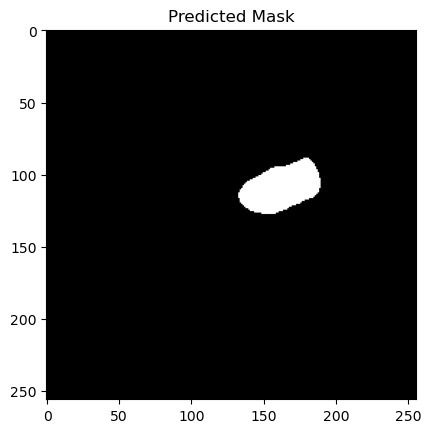

In [15]:
import matplotlib.pyplot as plt

plt.imshow(binary_preds[0][0].cpu(), cmap='gray')   # első batch első kép
plt.title("Predicted Mask")
plt.show()

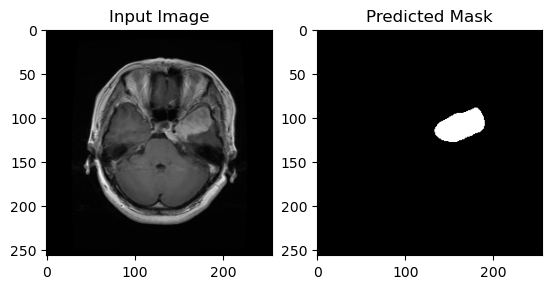

In [19]:
plt.subplot(1,2,1)
plt.imshow(image[0][0].cpu(), cmap='gray')
plt.title('Input Image')

plt.subplot(1,2,2)
plt.imshow(binary_preds[0][0].cpu(), cmap='gray')
plt.title('Predicted Mask')
plt.show()

In [21]:
torch.save(model.state_dict(),"C:/Users/marto/Desktop/Thesis/backend/models/unet_weights.pth")